# Test RAdam vs Adam on CIFAR-10

## Imports

In [153]:
import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import re
import seaborn as sns

from tensorflow import keras
import tensorflow_addons as tfa

sns.set_theme()

In [154]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train, x_valid = x_train[:30000], x_train[30000:]
y_train, y_valid = y_train[:30000], y_train[30000:]

In [155]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
        shear_range=0.1,        # set range for random shear
        zoom_range=0.1,         # set range for random zoom
        horizontal_flip=True    # randomly flip images
)
datagen.fit(x_train)

In [156]:
def get_model(num_classes):
    #define the convnet
    model = keras.models.Sequential()
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:], activation='relu'))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    # FLATTERN => DENSE => RELU => DROPOUT
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    
    # SOFTMAX
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    # Compile model
    return model

In [157]:
epochs = 50
batch_size = 64
rates = [-5, -3, -2]

In [158]:
# training loop: Adam
for i in rates:
    learning_rate = 10**i
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model = get_model(10)
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test), workers=4)
    model.save('model_adam_' + str(i) + '_.h5')
    with open(f'history_adam_{i}.pickle', 'wb') as f:
        pickle.dump(history.history, f)

  ...
    to  
  ['...']
Train for 469 steps, validate on 10000 samples
Epoch 1/50
469/469 [==============================] - 10s 21ms/step - loss: 2.3021 - accuracy: 0.1112 - val_loss: 2.2938 - val_accuracy: 0.1469
Epoch 2/50
469/469 [==============================] - 10s 21ms/step - loss: 2.2845 - accuracy: 0.1351 - val_loss: 2.2673 - val_accuracy: 0.2048
Epoch 3/50
469/469 [==============================] - 10s 22ms/step - loss: 2.2083 - accuracy: 0.1826 - val_loss: 2.0996 - val_accuracy: 0.2627
Epoch 4/50
469/469 [==============================] - 9s 20ms/step - loss: 2.0789 - accuracy: 0.2277 - val_loss: 2.0023 - val_accuracy: 0.2916
Epoch 5/50
469/469 [==============================] - 9s 20ms/step - loss: 2.0211 - accuracy: 0.2518 - val_loss: 1.9322 - val_accuracy: 0.3274
Epoch 6/50
469/469 [==============================] - 10s 21ms/step - loss: 1.9553 - accuracy: 0.2837 - val_loss: 1.8605 - val_accuracy: 0.3523
Epoch 7/50
469/469 [==============================] - 10s 20ms/ste

In [159]:
# training loop: RAdam
for i in rates:
    learning_rate = 10**i
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
    model = get_model(10)
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test), workers=4)
    model.save('model_radam_' + str(i) + '_.h5')
    with open(f'history_radam_{i}.pickle', 'wb') as f:
        pickle.dump(history.history, f)

  ...
    to  
  ['...']
Train for 469 steps, validate on 10000 samples
Epoch 1/50
469/469 [==============================] - 12s 26ms/step - loss: 2.3073 - accuracy: 0.0979 - val_loss: 2.3002 - val_accuracy: 0.1149
Epoch 2/50
469/469 [==============================] - 11s 22ms/step - loss: 2.2981 - accuracy: 0.1101 - val_loss: 2.2920 - val_accuracy: 0.1177
Epoch 3/50
469/469 [==============================] - 10s 22ms/step - loss: 2.2827 - accuracy: 0.1341 - val_loss: 2.2639 - val_accuracy: 0.1470
Epoch 4/50
469/469 [==============================] - 10s 22ms/step - loss: 2.2203 - accuracy: 0.1755 - val_loss: 2.1210 - val_accuracy: 0.2664
Epoch 5/50
469/469 [==============================] - 11s 22ms/step - loss: 2.0684 - accuracy: 0.2320 - val_loss: 1.9553 - val_accuracy: 0.3209
Epoch 6/50
469/469 [==============================] - 11s 22ms/step - loss: 1.9741 - accuracy: 0.2712 - val_loss: 1.8732 - val_accuracy: 0.3496
Epoch 7/50
469/469 [==============================] - 10s 22ms/s

In [160]:
# training loop: RAdam with start-up
iterations = epochs * len(x_train) // batch_size
for i in rates:
    learning_rate = 10**i
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate, total_steps=iterations)
    model = get_model(10)
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(x_test, y_test), workers=4)
    model.save('model_radam_warmup_' + str(i) + '_.h5')
    with open(f'history_radam_warmup_{i}.pickle', 'wb') as f:
        pickle.dump(history.history, f)

  ...
    to  
  ['...']
Train for 469 steps, validate on 10000 samples
Epoch 1/50
469/469 [==============================] - 13s 29ms/step - loss: 2.3135 - accuracy: 0.0993 - val_loss: 2.3023 - val_accuracy: 0.1016
Epoch 2/50
469/469 [==============================] - 11s 24ms/step - loss: 2.3090 - accuracy: 0.1030 - val_loss: 2.2980 - val_accuracy: 0.1321
Epoch 3/50
469/469 [==============================] - 11s 24ms/step - loss: 2.3002 - accuracy: 0.1117 - val_loss: 2.2914 - val_accuracy: 0.1567
Epoch 4/50
469/469 [==============================] - 11s 23ms/step - loss: 2.2867 - accuracy: 0.1276 - val_loss: 2.2731 - val_accuracy: 0.1914
Epoch 5/50
469/469 [==============================] - 11s 24ms/step - loss: 2.2411 - accuracy: 0.1615 - val_loss: 2.1696 - val_accuracy: 0.2349
Epoch 6/50
469/469 [==============================] - 11s 24ms/step - loss: 2.1232 - accuracy: 0.2051 - val_loss: 2.0447 - val_accuracy: 0.2671
Epoch 7/50
469/469 [==============================] - 11s 23ms/s

In [183]:
# Load history data from pickle files
optimizers = []
histories = []
learning_rates = []
for file in glob.glob('./history_*'):
    with open(file, 'rb') as f:
        histories.append(pickle.load(f))
    info = re.split('[\\\.]+', file)[1].rsplit('history_')[1].rsplit('_')
    optimizers.append(' '.join(info[:-1]).title())
    learning_rates.append(info[-1])

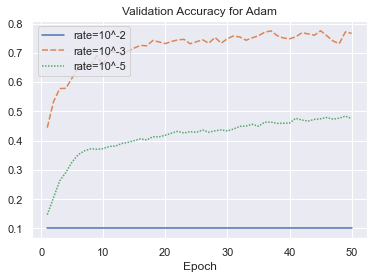

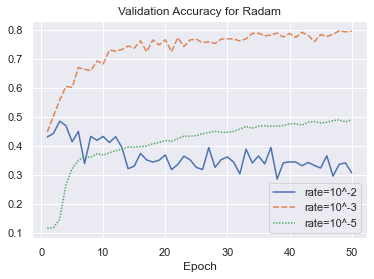

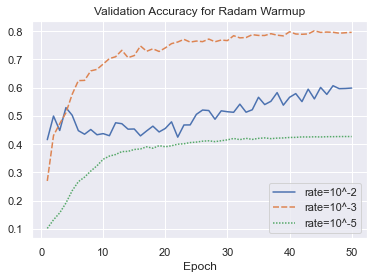

In [191]:
# Plot Validation Accuracy
for optimizer in set(optimizers):
    indices = [i for i, opt in enumerate(optimizers) if opt == optimizer]
    plot_data = []
    for i in indices:
        plot_data.append(histories[i]['val_accuracy'])
    legend_entries = ['rate=10^' + rate for rate in [learning_rates[i] for i in indices]]
    plot_data = pd.DataFrame(np.array(plot_data).transpose(), columns=legend_entries)
    plot_data.index = np.arange(1,len(plot_data)+1)
    plot_data.rename_axis(index='Epoch', inplace=True)
    
    plt.figure()
    sns.lineplot(data=plot_data).set(title='Validation Accuracy for '+ optimizer)